# **Lab 4: Adversarial Attacks Against Machine Learning Based Spam Filters**

Please Type the Names of the Team Members:

## **Introduction**
Machine learning-based spam detection models learn from a set of labeled training data and detect spam emails. One class of vulnerabilities can help an attack to slightly modify the spam emails, called adversarial examples, to manipulate a trained model, e.g., a support vector machine(SVM) classifier, to misclassify maliciously during detection. However, feature extraction methods can make it difficult to translate numerical changes in the feature space, to needed changes to an email consisting of words.

This lab uses a new attack method to understand how adversarial examples purposely modify the TF-IDF (term frequency-inverse document frequency) feature vector representing an email. A set of "magic words", or "malicious words" are identified from the TF-IDF vectors that experience the most significant changes made by a Projected Gradient Descent (PGD) algorithm. Adding these magic words to a spam email increases the chance for desirable misclassifications.

## **Publications**

For more information on this method, you can refer to the following publications:

(1) C. Wang, D. Zhang, S. Huang, X. Li, and L. Ding, “Crafting Adversarial Email Content against Machine Learning Based Spam Email Detection,” In Proceedings of the 2021 International Symposium on Advanced Security on Software and Systems (ASSS ’21) with AsiaCCS 2021, Virtual Event, Hong Kong, June 7, 2021. [Download](https://isi.jhu.edu/wp-content/uploads/2021/04/ASSS_Workshop_Paper.pdf)

(2) Q. Cheng, A. Xu, X. Li, and L. Ding, “Adversarial Email Generation against Spam Detection Models through Feature Perturbation,” The 2022 IEEE International Conference on Assured Autonomy (ICAA’22), Virtual Event, March 22-23, 2022. [Download](https://isi.jhu.edu/wp-content/uploads/2022/04/Adversarial_Attacks_Against_Machine_Learning_Based_SpamFilters__IEEE.pdf)

## **1. Loading Dataset**
The dataset to be used is called Ling-Spam. The Ling-Spam dataset is a collection of 2,893 spam and ham email messages curated from the Linguist List. These messages focus on linguistic interests around job postings, research opportunities, and software discussion. You can download this dataset below coming with the lab assignment.

### Acknowledgements
The dataset and its information come from the original authors of "A Memory-Based Approach to Anti-Spam Filtering for Mailing Lists". \\

**Run the code block below:**

choose the message.csv to upload. Wait until it shows 100% before you continue. The below code is for the "Google Colab" environment, for another environment (like Jupyter Notebook), you can choose the corresponding upload function.

In [8]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving messages.csv to messages (3).csv


**Run the code block below:**

This splits the loaded dataset into three subsets of training, validation, and testing.

In [9]:
from sklearn.model_selection import train_test_split


def data_extraction():

  # Change the 'messages.csv' to the filename you uploaded.
  df = pd.read_csv('messages.csv')
  x = df.message
  y = df.label
  # We first separate the entire dataset to 80% and 20%.
  # Let the 80% of entire dataset becoming the first dataset(which will be split to traning dataset and the validation dataset), and let the 20% of entire dataset becoming the testing dataset.
  x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=99, stratify=y)
  # Let the 80% of the train_val dataset be the traning dataset, and the 20% of the train_val dataset be the validation dataset.
  x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=99, stratify=y_train_val)


  return x_train, x_val, x_test, y_train, y_val, y_test




In [10]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = data_extraction()
print(X_train)

2304    content length student net looking reference f...
1412    anthropological linguistics volume number wint...
2124    pre final programme participation workshop lan...
416     putting syllabus undergraduate sociolinguistic...
2058    twendial th twente workshop language technolog...
                              ...                        
2294    h stephen straight right mention importance es...
1059    hi wondering interested subscribing optin emai...
36      interested making day month willing forth hone...
1660    kyushu institute technology national universit...
446     international conference linguistics marking a...
Name: message, Length: 1480, dtype: object


In the code block above, we have read the dataset into variables x
and y. Variable x contains the email body in a list of words and variable y contains the class labels with 0 being ham and 1 being spam.

We divide the entire data set randomly into three different data sets which are training data, validation data, and testing data. After we split the dataset twice: 64% of the entire dataset becomes the traning dataset(Y_train), 16% becomes the validation dataset(X_val), and 20% becomes the testing dataset(X_test).


### **Question 1**

Why do we need the three data subsets described above? Please explain what is a training dataset, a validation dataset, and a testing dataset. For some additional insights, you can refer to the article at https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7. (However, note that the validation dataset is also used to identify the magical words in this lab, kind of different from its typical use.)

## **2. Preprocessing the Emails**
For preparation for use, we remove all the HTML tags, numbers, punctuation marks, and English stop words to keep only useful information. We also convert all the words to lowercase and each paragraph into a single line instead of multiple lines. In the last step of preprocessing, we conduct stemming on all the words.

\\
**Run the code block below:**

In [14]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


# Remove the hyperlink.
def remove_hyperlink(word):

    return re.sub(r"http\S+", " ", word)


# Convert the letter to lowercase.
def to_lower(word):
    result = word.lower()

    return result


# Remove the numbers.
def remove_number(word):
    result = re.sub(r'\d+', ' ', word)

    return result


# Remove the puncturations.
def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))

    return result


# Remove the whitespace.
def remove_whitespace(word):
    result = word.strip()

    return result


# Merge multiple lines into one line.
def replace_newline(word):

    return word.replace('\n', ' ')


def clean_up_pipeline(sentence):
    # Ensure the input is a string
    if not isinstance(sentence, str):
        sentence = str(sentence)

    cleaning_utils = [remove_hyperlink, replace_newline, to_lower, remove_number, remove_punctuation, remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)

    return sentence


# Remove the stopwords, for example: a, and, an, above, ..., etc.
def remove_stop_words(words):
    result = [i for i in words if i not in ENGLISH_STOP_WORDS]

    return result


# Reduce a word to its root word.
def word_stemmer(words):
    stemmer = PorterStemmer()

    return [stemmer.stem(o) for o in words]


# Remove inflectional endings only and to return the base.
def word_lemmatizer(words):
    lemmatizer = WordNetLemmatizer()

    return [lemmatizer.lemmatize(o) for o in words]


# Clear out the unnecessary information.
def clean_token_pipeline(words):
    cleaning_utils = [remove_stop_words, word_lemmatizer]

    for o in cleaning_utils:
        words = o(words)

    return words


def preprocess(X_train, X_val, X_test):
    # Ensure all elements are strings
    X_train = [str(x) if not isinstance(x, str) else x for x in X_train]
    X_test = [str(x) if not isinstance(x, str) else x for x in X_test]
    X_val = [str(x) if not isinstance(x, str) else x for x in X_val]

    x_train_clean = [clean_up_pipeline(o) for o in X_train]
    x_test_clean = [clean_up_pipeline(o) for o in X_test]
    x_val_clean = [clean_up_pipeline(o) for o in X_val]
    x_train_tokenize = [word_tokenize(o) for o in x_train_clean]
    x_test_tokenize = [word_tokenize(o) for o in x_test_clean]
    x_val_tokenize = [word_tokenize(o) for o in x_val_clean]
    x_train_clean_token = [clean_token_pipeline(o) for o in x_train_tokenize]
    x_test_clean_token = [clean_token_pipeline(o) for o in x_test_tokenize]
    x_val_clean_token = [clean_token_pipeline(o) for o in x_val_tokenize]
    x_train = [" ".join(o) for o in x_train_clean_token]
    x_test = [" ".join(o) for o in x_test_clean_token]
    x_val = [" ".join(o) for o in x_val_clean_token]

    return x_train, x_val, x_test

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [15]:
x_train, x_val, x_test = preprocess(X_train, X_val, X_test)
print(x_train[0])

content length student net looking reference formal systematized description discourse dialog tour parole levison s work word use automatic analyzer political discourse topic local water syntax parsing d appreciate help provide answer directly walther uni unige ch ll post summary thanks catherine walther u geneva


## **3. Feature Extraction**
In this step, we convert the words of an email into a numerical feature vector, representing information of that email used for classification. Among many such methods, this lab will use TF-IDF. TF-IDF stands for term frequency-inverse document frequency. It is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in information retrieval and text mining. The TF-IDF value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.\\

\\
**Run the code block below:**

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
from scipy import sparse


vectorizer = TfidfVectorizer()


def convert_to_feature(raw_tokenize_data):
    raw_sentences = [' '.join(o) for o in raw_tokenize_data]

    return vectorizer.transform(raw_sentences)


def TfidfConvert(x_train, x_test, x_val):
    x_train = [o.split(" ") for o in x_train]
    x_test = [o.split(" ") for o in x_test]
    x_val = [o.split(" ") for o in x_val]
    x_train_raw_sentences = [' '.join(o) for o in x_train]
    x_val_raw_sentences = [' '.join(o) for o in x_val]
    raw_sentences = x_train_raw_sentences + x_val_raw_sentences
    vectorizer.fit(raw_sentences)
    x_train_features = convert_to_feature(x_train)
    x_test_features = convert_to_feature(x_test)
    x_val_features = convert_to_feature(x_val)


    return x_train_features, x_test_features, x_val_features


def feature_extraction(x_train, x_test, x_val):
    x_train_features, x_test_features, x_val_features = TfidfConvert(x_train, x_test, x_val)
    feature_names = vectorizer.get_feature_names_out()


    return x_train_features, x_test_features, x_val_features, feature_names, vectorizer, 'NaN'



In [17]:
x_train_features, x_test_features, x_val_features, feature_names, feature_model, scalar = feature_extraction(x_train, x_test, x_val)
print(x_train_features[0])

  (0, 41993)	0.07512236669900772
  (0, 41960)	0.07420235254046403
  (0, 41289)	0.17991300005024335
  (0, 41206)	0.4416403353969477
  (0, 40072)	0.07812616027660503
  (0, 39648)	0.202048950334105
  (0, 39606)	0.19564044624902785
  (0, 38439)	0.16153850115029383
  (0, 38358)	0.08616245901279183
  (0, 37792)	0.10145609731304224
  (0, 37059)	0.25008230228574047
  (0, 37025)	0.09136919891479676
  (0, 36634)	0.11034063903972836
  (0, 36292)	0.08922507669748314
  (0, 31432)	0.08371514431705784
  (0, 30368)	0.09759342420984102
  (0, 29460)	0.11486430860274591
  (0, 29279)	0.14093574571866804
  (0, 28054)	0.14041645906252576
  (0, 28043)	0.1857355165807253
  (0, 25837)	0.12124711013054038
  (0, 22395)	0.10974369781474626
  (0, 22260)	0.11604287133874543
  (0, 22204)	0.1099414410205347
  (0, 21695)	0.22082016769847385
  (0, 21565)	0.11350514919865842
  (0, 16306)	0.10026211056046669
  (0, 14560)	0.16580288301805737
  (0, 13616)	0.11328414191038517
  (0, 9830)	0.20539292784821994
  (0, 9746)	0.11

### **Question 2**
Please research TF-IDF online and provide a concise explanation of how it is done in your own words in one paragraph.

## **4. Training SVM**
In this step, we will train a Support Vector Machine (SVM) model as a spam filter. Then we use the validation dataset to evaluate how it performs.

**Run the code block below:**

In [18]:
!pip install secml
from secml.data import CDataset
from secml.data.splitter import CDataSplitterKFold
from secml.ml.classifiers import CClassifierSVM
from secml.ml.peval.metrics import CMetricAccuracy
from secml.ml.peval.metrics import CMetricConfusionMatrix
from secml.adv.attacks.evasion import CAttackEvasionPGD
# from Feature_extraction import single_transform
import csv
from statistics import mean, stdev
import threading
import time


# We use the training data and validation data set to train the SVM model.
def train_SVM(x_train_features, x_val_features, y_train, y_val):
    tr_set = CDataset(x_train_features, y_train)
    # Train the SVM
    print("Build SVM")
    xval_splitter = CDataSplitterKFold()
    clf_lin = CClassifierSVM()
    xval_lin_params = {'C': [1]}
    print("Find the best params")
    best_lin_params = clf_lin.estimate_parameters(
        dataset=tr_set,
        parameters=xval_lin_params,
        splitter=xval_splitter,
        metric='accuracy',
        perf_evaluator='xval'
    )
    print("Finish Train")
    print("The best training parameters are: ", [
          (k, best_lin_params[k]) for k in sorted(best_lin_params)])
    print("Train SVM")
    clf_lin.fit(tr_set.X, tr_set.Y)

    # Test the Classifier
    v_set = CDataset(x_val_features, y_val)
    y_pred = clf_lin.predict(v_set.X)
    metric = CMetricAccuracy()
    acc = metric.performance_score(y_true=v_set.Y, y_pred=y_pred)
    confusion_matrix = CMetricConfusionMatrix()
    cm = confusion_matrix.performance_score(y_true=v_set.Y, y_pred=y_pred)
    print("Confusion Matrix: ")
    print(cm)


    return tr_set, v_set, clf_lin



In [19]:
tr_set, v_set, clf_lin = train_SVM(x_train_features, x_val_features, Y_train, Y_val)

Build SVM
Find the best params
Finish Train
The best training parameters are:  [('C', 1)]
Train SVM
Confusion Matrix: 
CArray([[309   0]
 [  3  59]])


### **Question 3**
Based on the confusion matrix provided above, calculate the following metrics: `accuracy`, `false-positive rate`, `false-negative rate`, `true-positive rate`, and `true-negative rate`. Please outline the steps you took to calculate each metric and include your results in the text block below. Additionally, provide an explanation of each metric in the context of spam email detection.

## **5. PGD Attack**
Adversarial perturbations are made to input features, i.e., the TF-IDF values corresponding to words. We employ the Projected Gradient Descent (PGD) method to modify the feature values for desirable adversarial examples in the feature domain. PGD algorithm iteratively finds the needed changes with a constraint parameter, *dmax*, which is the Euclidean distance to the original input indicating the allowed extent of perturbation, to achieve the maximum loss in classification. In our approach, we run PGD over a set of randomly selected spam emails form the validation sataset to generate adversarial examples in the feature space. Then we test these modified TF-IDF vectors to see whether they could successfully bypass the detection. \\

\\
**Run the code block below:**

**Note:**
These are explanations for the terms used in the code:

1. `clf_lin` - SVM Classifier:
   - Represents a Support Vector Machine (SVM) classifier for email classification.

2. `tr_set` - Training Set:
   - A dataset used for training the SVM classifier, containing input features and labels.

3. `v_set` - Validation Set:
   - A dataset used to identify the "best" magic words through PGD.

4. `Y_val` - Validation Set Labels:
   - Contains labels for the validation set, aiding in performance evaluation.

5. `feature_names` - Name of the Features:
   - Likely holds the names or labels of the dataset's features.

6. `nb_attack` - Number of Attacks:
   - Determines how many adversarial examples should be generated (the number of spam emails to modify by PGD).

7. `dmax` - Maximum Perturbation Distance:
   - Represents the maximum allowed change in feature values during adversarial attacks, measured as Euclidean distance.

8. `lb` - Lower Bound:
   - Sets a lower boundary on feature values, constraining perturbations during attacks.

9. `ub` - Upper Bound:
   - Defines an upper boundary on feature values, limiting perturbations during attacks.


In [20]:
def pgd_attack(clf_lin, tr_set, v_set, y_val, feature_names, nb_attack, dmax, lb, ub):

    class_to_attack = 1
    cnt = 0  # the number of success adversaril examples
    ori_examples2_x = []
    ori_examples2_y = []

    for i in range(nb_attack):
        # take a point at random being the starting point of the attack
        idx_candidates = np.where(y_val == class_to_attack)
        # select nb_init_pts points randomly in candidates and make them move
        rn = np.random.choice(idx_candidates[0].size, 1)
        x0, y0 = v_set[idx_candidates[0][rn[0]], :].X, v_set[idx_candidates[0][rn[0]], :].Y

        x0 = x0.astype(float)
        y0 = y0.astype(int)
        x2 = x0.tondarray()[0]
        y2 = y0.tondarray()[0]

        ori_examples2_x.append(x2)
        ori_examples2_y.append(y2)


    # Perform adversarial attacks

    noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'

    y_target = 0

    # dmax = 0.09  # Maximum perturbation

    # Bounds of the attack space. Can be set to `None` for unbounded
    solver_params = {
        'eta': 0.01,
        'max_iter': 1000,
        'eps': 1e-4}

    # set lower bound and upper bound respectively to 0 and 1 since all features are Boolean
    pgd_attack = CAttackEvasionPGD(
        classifier=clf_lin,
        double_init_ds=tr_set,
        distance=noise_type,
        dmax=dmax,
        lb=lb, ub=ub,
        solver_params=solver_params,
        y_target=y_target
    )

    ad_examples_x = []
    ad_examples_y = []
    ad_index = []
    cnt = 0

    for i in range(len(ori_examples2_x)):
        x0 = ori_examples2_x[i]
        y0 = ori_examples2_y[i]
        y_pred_pgd, _, adv_ds_pgd, _ = pgd_attack.run(x0, y0)

        if y_pred_pgd.item() == 0:
            cnt = cnt + 1
            ad_index.append(i)

        ad_examples_x.append(adv_ds_pgd.X.tondarray()[0])
        ad_examples_y.append(y_pred_pgd.item())

        attack_pt = adv_ds_pgd.X.tondarray()[0]

    print("PGD attack successful rate:", cnt / nb_attack)

    startTime2 = time.time()
    ori_examples2_x = np.array(ori_examples2_x)
    ori_examples2_y = np.array(ori_examples2_y)
    ad_examples_x = np.array(ad_examples_x)
    ad_examples_y = np.array(ad_examples_y)

    ori_dataframe = pd.DataFrame(ori_examples2_x, columns=feature_names)
    ad_dataframe = pd.DataFrame(ad_examples_x, columns=feature_names)

    # extract the success and fail examples

    ad_dataframe['ad_label'] = ad_examples_y
    ad_success = ad_dataframe.loc[ad_dataframe.ad_label == 0]
    ori_success = ori_dataframe.loc[ad_dataframe.ad_label == 0]
    ad_fail = ad_dataframe.loc[ad_dataframe.ad_label == 1]
    ori_fail = ori_dataframe.loc[ad_dataframe.ad_label == 1]

    ad_success_x = ad_success.drop(columns=['ad_label'])
    ad_fail_x = ad_fail.drop(columns=['ad_label'])

    result = (ad_success_x - ori_success)
    ori_dataframe.to_csv('ori_dataframe.csv')
    ad_dataframe.to_csv('ad_dataframe.csv')
    result.to_csv('result.csv')



    return result, cnt, ad_success_x, ori_dataframe, ori_examples2_y, cnt/nb_attack

**Then run the code block below:**

In [21]:
lb = np.ndarray.min(x_train_features.toarray())
ub = np.ndarray.max(x_train_features.toarray())
attack_amount = 100
dmax = 0.06
result, cnt, ad_success_x, ori_dataframe, ori_examples2_y, successful_rate = pgd_attack(clf_lin, tr_set, v_set, Y_val, feature_names, attack_amount, dmax, lb, ub)

PGD attack successful rate: 0.13


### **Question 4**
Please explain, in your own words, how the success rate is calculated based on the code above. Then, compare this success rate to the original false negative rate of the classifier on the validation set. What do you observe from this comparison?

## **6. Identifying Magical Words**
Adversarial emails are crafted by adding “magic words” to the original spam emails. The “magic words” are identified by intersecting the unique ham words with the “top words”. Specifically,  the unique ham words only appear in ham emails but not in spam emails.  After the  PGD  attacks on the set of randomly selected spam emails, we examine statistically which features are modified to the largest extent in the effort to bypass detection, to find their corresponding “top words”. (The changes are measured by calculating the variance of TF-IDF differences ver these spam emails before and after the PGD perturbation.) In  our  experiments,  we  use  the  top 100  words,  which  is relatively efficient. This set is relatively small and effective. \\

\\
**Run the code block below:**

In [34]:
def magical_word(x_train, x_val, y_train, y_val, x_test, y_test, result, cnt):

    # Method 2: calculate feature importance
    result_array = np.array(result)
    weighted_result = result.multiply(result_array)

    average_importance = weighted_result.sum() / cnt
    average_importance_df = pd.DataFrame(average_importance, columns=['importance'])
    sorted_features = average_importance_df.sort_values(by='importance', ascending=False, inplace=False)

    important_features_df = pd.DataFrame(sorted_features.index[:100])
    important_features_df.to_csv("important_features.csv")

    # Combine train and validation datasets
    train_data = pd.DataFrame({'message': x_train, 'label': y_train})
    val_data = pd.DataFrame({'message': x_val, 'label': y_val})
    combined_data = pd.concat([train_data, val_data])
    combined_data.to_csv("combined_messages.csv")

    # Separate spam and ham messages
    spam_messages = combined_data[combined_data.label == 1]
    ham_messages = combined_data[combined_data.label == 0]

    # Save test messages
    test_data = pd.DataFrame({'message': x_test, 'label': y_test})
    test_data.to_csv("test_messages.csv")
    spam_test_messages = test_data[test_data.label == 1]

    # Tf-idf for spam datasets
    tfidf_vectorizer_spam = TfidfVectorizer()
    tfidf_vectorizer_spam.fit_transform(spam_messages['message'])
    spam_feature_names = tfidf_vectorizer_spam.get_feature_names_out()

    # Tf-idf for ham datasets
    tfidf_vectorizer_ham = TfidfVectorizer()
    tfidf_vectorizer_ham.fit_transform(ham_messages['message'])
    ham_feature_names = tfidf_vectorizer_ham.get_feature_names_out()

    # find unique ham words
    unique_ham_words = list(set(ham_feature_names) - set(spam_feature_names))
    unique_ham_words_df = pd.DataFrame(unique_ham_words)
    unique_ham_words_df.to_csv("unique_ham_words.csv")

    with open("important_features.csv", "r") as csvfile:
        reader = csv.reader(csvfile)
        important_features = [row[1] for row in reader]

    important_features = important_features[1:]
    # in ham & top100

    ham_words_in_important_features = list(set(unique_ham_words).intersection(set(important_features)))
    ham_words_str = " ".join(ham_words_in_important_features)

    return ham_words_str, spam_messages, ham_messages, spam_test_messages



**Run the code block below to list the magic words:**

Variable identified_magic_words contains the identified magic words.

In [35]:
identified_magic_words, spam, ham, spam_test = magical_word(x_train, x_val, Y_train, Y_val, x_test, Y_test, result, cnt)
print(identified_magic_words)
print(len(identified_magic_words.split()))

teaching vt marvelous workshop linguist risked ammondt latin spanish translation french alinguist benjamin ipa linguistic siouan colingacl tei teacher uga sentence euralex german chorus elra cascadilla nan
27


### **Question 5**
(1). Based on your understanding after reading the paper using the link below, explain what is a "good word" attack?
(Reference: https://www.ceas.cc/papers-2005/125.pdf)


(2). The use of the good words is similar to our "magic words" in this approach.
What is the difference in finding "magic words" from finding "good words"?



### **Task 1**
In the code block below, try to run pgd_attack with different dmax values.

What will happen when you try a higher dmax? Show the relationship by plotting dmax values and the corresponding PGD attack successful rate in a graph. You can do this by changing the code below with different dmax values. Try at least 5 dmax and explain your findings.

PGD attack successful rate: 0.14


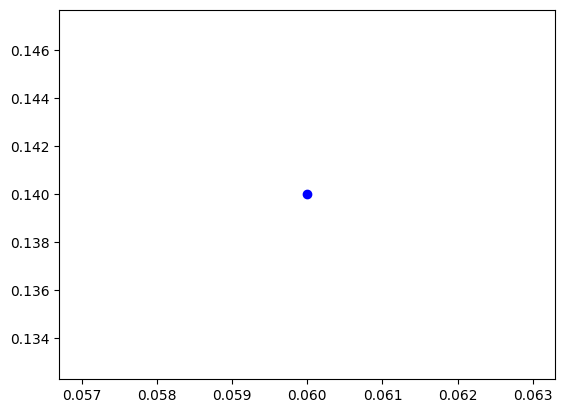

In [24]:
import matplotlib.pyplot as plt

attack_amount = 100
dmax = 0.06
result, cnt, ad_success_x, ori_dataframe, ori_examples2_y, successful_rate = pgd_attack(clf_lin, tr_set, v_set, Y_val, feature_names, attack_amount, dmax, lb, ub)

# this plot cotains a single dmax vs the successful rate,
# you can either write a for loop to try 5 or more dmax, or just manually
# modify dmax values and record the results.
list_dmax = [dmax]
list_successful_rate = [successful_rate]
plt.plot(list_dmax, list_successful_rate, 'b-o')

### **Task 2**
How many magical words did you get in attacks? List the magical words in the following text block. Find the relationship between the number of magical words and dmax of PGD attack. Plot a graph to show this relationship. Try at least 5 different dmax values. Explain your findings.


PGD attack successful rate: 0.15


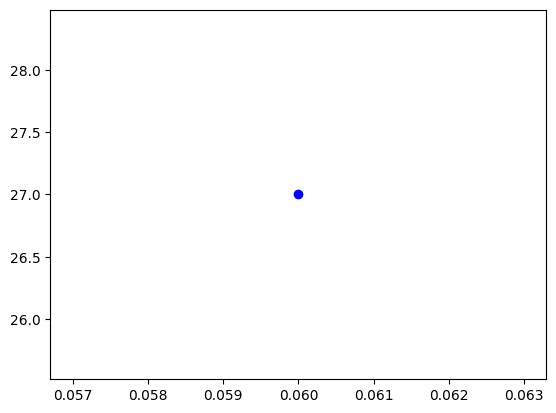

In [25]:
attack_amount = 100
dmax = 0.06
result, cnt, ad_success_x, ori_dataframe, ori_examples2_y, successful_rate = pgd_attack(clf_lin, tr_set, v_set, Y_val, feature_names, attack_amount, dmax, lb, ub)
identified_magic_words, spam, ham, spam_test = magical_word(x_train, x_val, Y_train, Y_val, x_test, Y_test, result, cnt)

# this plot cotains a single dmax vs the number of magical words,
# you can either write a for loop do to 5 or more dmax, or just manually
# record dmax values
list_dmax = [dmax]
list_len = [len(identified_magic_words.split())]
#print (identified_magic_words)
#print(list_len)
plt.plot(list_dmax, list_len, 'b-o')

## **7. Crafting Adversarial Emails & Attacking SVM**
After we find the magical words, we then add them to a spam email to evaluate how effectively the "magic words" can bypass the classifier. This is what we called "crafting adversarial emails". Then, we feed the new TF-IDF vectors of these crafted emails to the SVM classifier to see if they would be misclassified as ham emails.  \\

\\
**Run the code block below:**


In [26]:
m2_empty = pd.DataFrame()
spam_cnt = 0
threads = []
m2_empty_l1 = pd.DataFrame()
m2_empty_l2 = pd.DataFrame()
m2_empty_l3 = pd.DataFrame()
m2_empty_l4 = pd.DataFrame()
m2_list = [m2_empty_l1, m2_empty_l2, m2_empty_l3, m2_empty_l4]


def single_transform(x, method, feature_model, feature_names, scalar, selection_model):

  result = feature_model.transform(x)

  if selection_model != 'NaN':
    result = selection_model.transform(result)


  return result



class myThread(threading.Thread):

    def __init__(self, threadID, name, spam_message, identified_magic_words, method, feature_model, feature_names, scalar, clf_lin, list_index, selection_model):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.spam_message = spam_message
        self.identified_magic_words = identified_magic_words
        self.method = method
        self.feature_model = feature_model
        self.feature_names = feature_names
        self.scalar = scalar
        self.clf_lin = clf_lin
        self.list_index = list_index
        self.lock = threading.Lock()
        self.selection_model = selection_model

    def run(self):
        global spam_cnt
        print("Starting " + self.name)
        spam_cnt_1 = m2_empty_out(self.name, self.spam_message, self.identified_magic_words, self.method,
                                  self.feature_model, self.feature_names, self.scalar, self.clf_lin,
                                  self.list_index, self.selection_model)
        spam_cnt = spam_cnt+spam_cnt_1
        time.sleep(0.1)
        print("Exiting " + self.name)



def m2_empty_out(name, spam_message, identified_magic_words, method, feature_model, feature_names, scalar, clf_lin, list_index, selection_model):
    m2_empty_1 = pd.DataFrame()
    spam_cnt_1 = 0
    global m2_list

    for j in spam_message.message:
        choose_email = [j + identified_magic_words]
        message_14_email = pd.DataFrame(choose_email, columns=["message"])
        message_14_tf_idf = single_transform(
            message_14_email["message"], method, feature_model, feature_names, scalar, selection_model)
        message_14_tf_idf = pd.DataFrame(
            message_14_tf_idf.toarray(), columns=feature_names)
        message_14_y = [1]
        message_14_y = pd.Series(message_14_y)
        message_CData = CDataset(message_14_tf_idf, message_14_y)
        message_14_pred = clf_lin.predict(message_CData.X)

        if message_14_pred == 0:
            spam_cnt_1 += 1
            m2_empty_1 = pd.concat([m2_empty_1, message_14_tf_idf], ignore_index=True)

    m2_list[list_index] = pd.concat([m2_list[list_index], m2_empty_1], ignore_index=True)

    return spam_cnt_1




def svm_attack(method, clf_lin, spam, identified_magic_words, feature_model, feature_names, scalar, selection_model):

    global m2_empty

    spam_messages = np.array_split(spam, 4)

    print("Start processing message")

    thread1 = myThread(1, "Thread-1", spam_messages[0], identified_magic_words,
                       method, feature_model, feature_names, scalar, clf_lin, 0, selection_model)
    thread2 = myThread(2, "Thread-2", spam_messages[1], identified_magic_words,
                       method, feature_model, feature_names, scalar, clf_lin, 1, selection_model)
    thread3 = myThread(3, "Thread-3", spam_messages[2], identified_magic_words,
                       method, feature_model, feature_names, scalar, clf_lin, 2, selection_model)
    thread4 = myThread(4, "Thread-4", spam_messages[3], identified_magic_words,
                       method, feature_model, feature_names, scalar, clf_lin, 3, selection_model)

    threads.append(thread1)
    threads.append(thread2)
    threads.append(thread3)
    threads.append(thread4)

    for t in threads:
        t.start()

    for t in threads:
        t.join()

    m2_empty = pd.concat(m2_list, ignore_index=True)

    print("Exiting Main Thread")
    print('White box attack on SVM:')
    print('Number of samples provided:', len(spam))
    print('Number of crafted sample that got misclassified:', spam_cnt)
    print('Successful rate:', spam_cnt / len(spam))

    return m2_empty


**Run the code block below:**

In [27]:
m2_empty = svm_attack('TFIDF', clf_lin, spam_test, identified_magic_words, feature_model, feature_names, scalar, 'NaN')

  return bound(*args, **kwds)



Start processing message
Starting Thread-1
Starting Thread-2Starting Thread-3
Starting Thread-4

Exiting Thread-1
Exiting Thread-3
Exiting Thread-2
Exiting Thread-4
Exiting Main Thread
White box attack on SVM:
Number of samples provided: 77
Number of crafted sample that got misclassified: 45
Successful rate: 0.5844155844155844


### **Question 6**
Is the successful rate shown above higher or lower than the false negative rate of the classifer? Does that mean our attack is effective?

### **Task 4**
Now we will try to craft individual emails by manually changing the text.
Follow the steps below for 5 emails: \\

1. Choose an email from the spam dataset.
2. Copy the selected email into the code block.
3. Add a single magical word obtained from the results of Section 6 to the email, placing it where you see fit.
4. Run the code to check if the label is flipped from spam (1) to non-spam (0).
5. If the label is flipped, stop. If not, repeat steps 3 and 4 (*add additional magic word*) until the label is flipped or until you've run out of magical words.

Tips:
1. Here you should note, what exactly is "Spam Emails" in this case.
2. What should the magical words added to spam_emails be generated from? Is it our validation data or test data?

In [28]:
# All Spam Emails
print(spam_test)

                                                message  label
1846  virtual girlfriend virtual boyfriend artificia...      1
1501  warning great interested visit web site http c...      1
965   list owner kiddin invited join mailing list li...      1
1027  dear friend responded following announcement d...      1
1594  sexxx site approved clinton click click remove...      1
...                                                 ...    ...
1411  b r g n r f r e s stop travel supplier air hot...      1
2144  dear internet user dear internet user sound fa...      1
347   k st mo income home based business booming mlm...      1
80    innovative publically traded company offer par...      1
1068  earn month home based business legally pay lit...      1

[77 rows x 2 columns]


In [29]:
# Choose by varying numbers
print(spam_test.message.values[0])

virtual girlfriend virtual boyfriend artificial intelligence program ibm pc compatible macintosh watch talk ask question tell secret relate watch ask different clothes guide different activity watch participate hottest sexual activity available computer including sexual position using unique toy bringing multiple partner doubt realistic sexually stimulating computer game available remember birthday like dislike time start program say different thing act differently time different personality vga digital graphic virtual girlfriend virtual boyfriend software hottest sexiest graphic soundblaster compatible card actually hear voice talk adult software title designed heterosexual homosexual people like try actual copy market sold actual price information people think program try write comment thank interested like order copy read mailing instruction come unmarked package sent day order received mailing list whatsoever guaranteed run higher ibm compatibles required vga graphic hard drive sou

In [30]:
choose_email = ['The email content you chose + magical word']
message_14_email = pd.DataFrame(choose_email, columns=["message"])
message_14_tf_idf = single_transform(message_14_email["message"], 'TFIDF',
                    feature_model, feature_names, scalar,
                    'NaN')
message_14_tf_idf = pd.DataFrame(message_14_tf_idf.toarray(), columns=feature_names)
message_14_y = [1]
message_14_y = pd.Series(message_14_y)
message_CData = CDataset(message_14_tf_idf, message_14_y)
message_14_pred = clf_lin.predict(message_CData.X)

# if the output is something like CArray([0]), then you flipped the label
print('the label after injecting magical word:', message_14_pred)

the label after injecting magical word: CArray([0])


### **Question 7**
How many emails successfully went through (classifiction label flipped to 0) after adding magical words? For each of these emails, how many magical words did you add? (Choose at least 5 emails)